In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [3]:
icecream_df = pd.read_csv('../data/raw/icecream_sales.csv')

icecream_df.head(10)

,Temperature,Revenue
0,24.566884,534.799028
1,26.005191,625.190122
2,27.790554,660.632289
3,20.595335,487.706960
4,11.503498,316.240194
5,14.352514,367.940744
6,13.707780,308.894518
7,30.833985,696.716640
8,0.976870,55.390338
9,31.669465,737.800824


In [4]:
icecream_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  500 non-null    float64
 1   Revenue      500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB


In [5]:
icecream_df.describe()

,Temperature,Revenue
count,500.000000,500.000000
mean,22.232225,521.570777
std,8.096388,175.404751
min,0.000000,10.000000
25%,17.122258,405.558681
50%,22.392791,529.368565
75%,27.740674,642.257922
max,45.000000,1000.000000


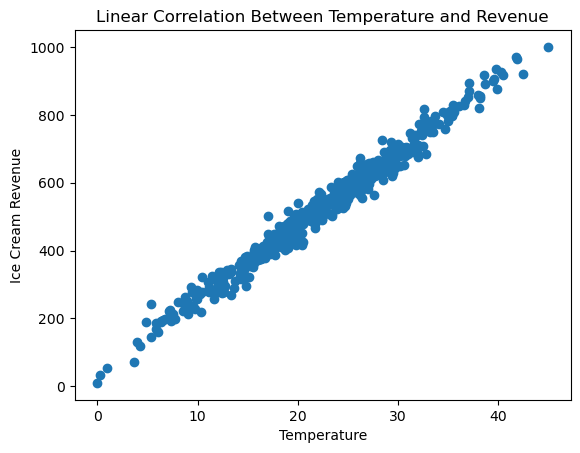

In [6]:
plt.title("Linear Correlation Between Temperature and Revenue")
plt.scatter(icecream_df['Temperature'], icecream_df['Revenue'])
plt.xlabel("Temperature")
plt.ylabel("Ice Cream Revenue")
plt.show()

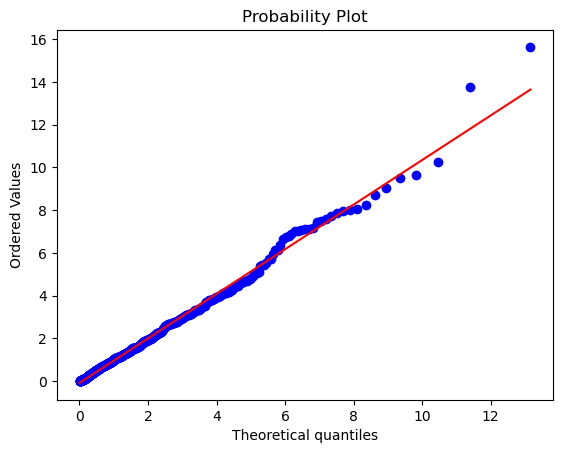

In [7]:
def mahalanobis(u, v, cov=None):
    """Function for calculating the Mahalanobis distance.

    Args:
        u (array_like): First array to measure the distance from.
        v (array_like): Second array to measure the distance to.
        cov (array_like, optional): Covariance matrix of the v array.
        Defaults to None.

    Returns:
        numpy.ndarray: Mahalanobis distance for every instance from the
        u array to the centroid of v.
    """
    if cov is None:
        cov = np.cov(v.to_numpy().T)

    u_mean_diff = u - np.mean(v, axis=0)
    inverse_cov_mat = np.linalg.inv(cov)

    mahal = np.dot(np.dot(u_mean_diff, inverse_cov_mat), u_mean_diff.T)

    return mahal.diagonal()

stats.probplot(mahalanobis(u = icecream_df, v = icecream_df), sparams=(2),
                           dist='chi2', plot=plt)
plt.show()

In [8]:
X = icecream_df['Temperature']
y = icecream_df['Revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

In [9]:
perceptron_regressor = tf.keras.models.Sequential()
perceptron_regressor.add(tf.keras.layers.Dense(units=1, input_shape=[1]))
perceptron_regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [10]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                           patience=10)

perceptron_regressor.compile(optimizer=tf.optimizers.Adam(0.1), loss='mse')
epochs_info = perceptron_regressor.fit(X_train, y_train, epochs=1000,
                                       callbacks=[early_stopping_callback])

Epoch 1/1000
13/13 [==============================] - 0s 3ms/step - loss: 277380.2500
Epoch 2/1000
13/13 [==============================] - 0s 615us/step - loss: 245642.0781
Epoch 3/1000
13/13 [==============================] - 0s 846us/step - loss: 215761.5781
Epoch 4/1000
13/13 [==============================] - 0s 849us/step - loss: 189008.4531
Epoch 5/1000
13/13 [==============================] - 0s 843us/step - loss: 164602.0469
Epoch 6/1000
13/13 [==============================] - 0s 692us/step - loss: 142599.4844
Epoch 7/1000
13/13 [==============================] - 0s 692us/step - loss: 123203.8438
Epoch 8/1000
13/13 [==============================] - 0s 769us/step - loss: 105686.0469
Epoch 9/1000
13/13 [==============================] - 0s 769us/step - loss: 90610.4531
Epoch 10/1000
13/13 [==============================] - 0s 615us/step - loss: 76899.3672
Epoch 11/1000
13/13 [==============================] - 0s 769us/step - loss: 65206.0859
Epoch 12/1000
13/13 [==============

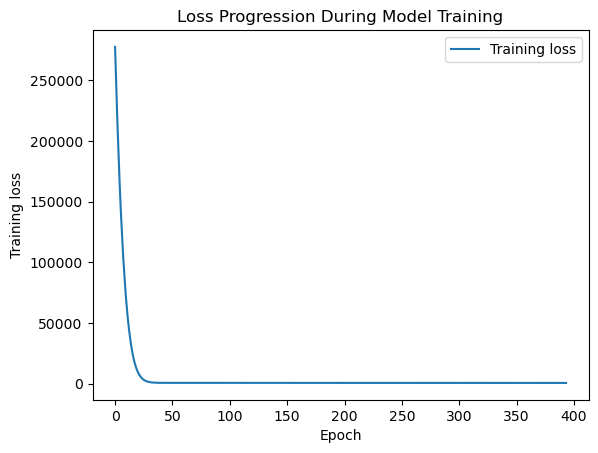

In [11]:
plt.plot(epochs_info.history['loss'])
plt.title("Loss Progression During Model Training")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.legend(["Training loss"])
plt.show()

Perceptron regressor weight:  [[21.709387]]
Perceptron regressor bias:  [39.081352]


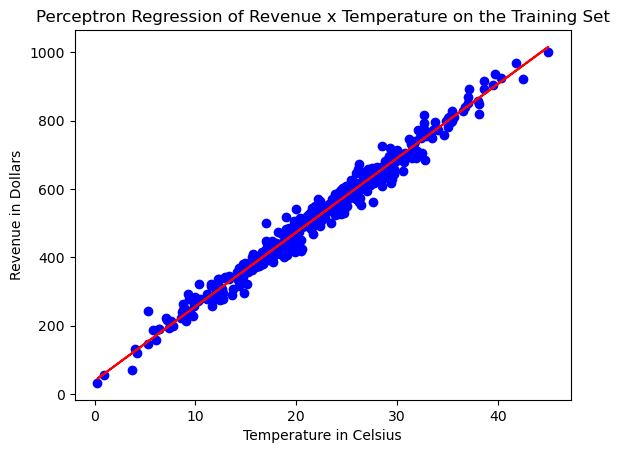

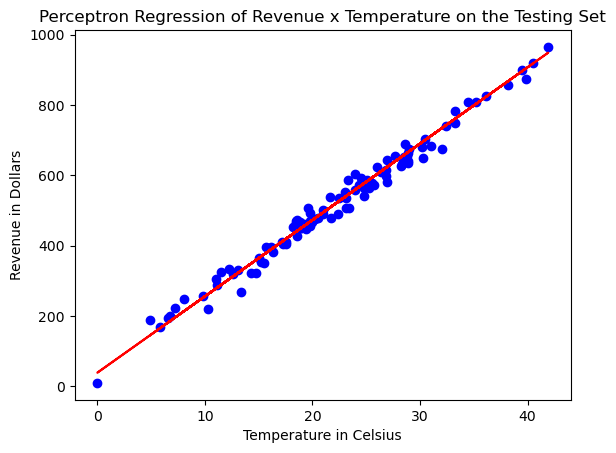

In [12]:
print("Perceptron regressor weight: ", perceptron_regressor.get_weights()[0])
print("Perceptron regressor bias: ", perceptron_regressor.get_weights()[1])

plt.scatter(X_train, y_train, color='b')
plt.plot(X_train, perceptron_regressor.predict(X_train), color='r')
plt.title("Perceptron Regression of Revenue x Temperature on the Training Set")
plt.xlabel("Temperature in Celsius")
plt.ylabel("Revenue in Dollars")
plt.show()

plt.scatter(X_test, y_test, color='b')
plt.plot(X_test, perceptron_regressor.predict(X_test), color='r')
plt.title("Perceptron Regression of Revenue x Temperature on the Testing Set")
plt.xlabel("Temperature in Celsius")
plt.ylabel("Revenue in Dollars")
plt.show()

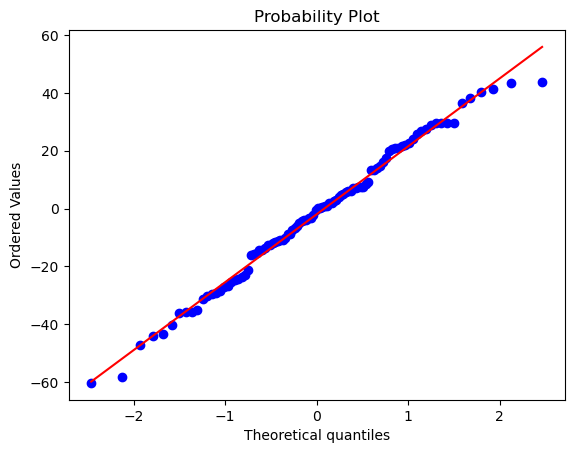

In [13]:
X_test_prediction = perceptron_regressor.predict(X_test).ravel()
X_test_residuals = y_test - X_test_prediction

stats.probplot(X_test_residuals, dist='norm', plot=plt)
plt.show()

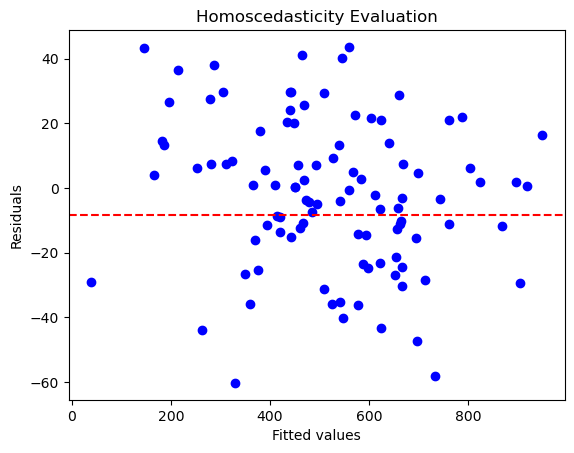

In [20]:
midpoint = (np.max(X_test_residuals) + np.min(X_test_residuals)) / 2

plt.title("Homoscedasticity Evaluation")
plt.scatter(X_test_prediction, X_test_residuals, color='b')
plt.axhline(midpoint, color='r', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

Linear regression coefficient:  [[21.5133908]]
Linear regression intercept:  [43.73357869]


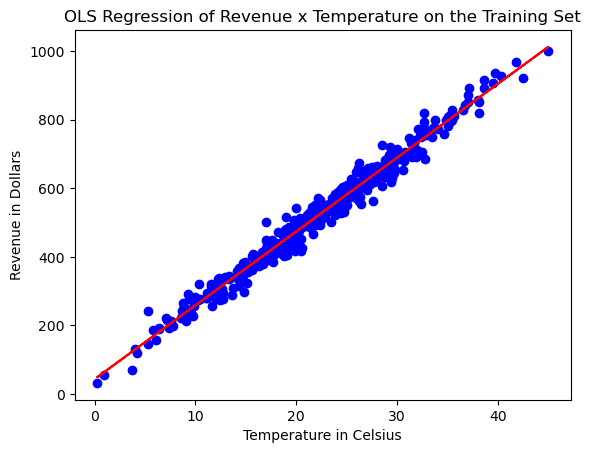

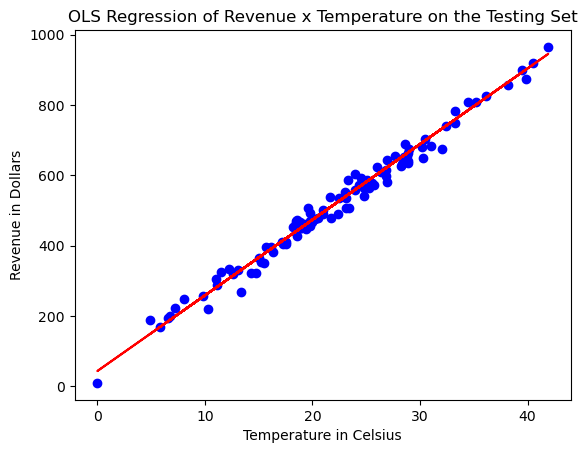

In [15]:
X_train_reshaped = X_train.to_numpy().reshape(-1, 1)
y_train_reshaped = y_train.to_numpy().reshape(-1, 1)
X_test_reshaped = X_test.to_numpy().reshape(-1, 1)
y_test_reshaped = y_test.to_numpy().reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(X_train_reshaped, y_train_reshaped)

print("Linear regression coefficient: ", linear_regressor.coef_)
print("Linear regression intercept: ", linear_regressor.intercept_)

plt.scatter(X_train, y_train, color='b')
plt.plot(X_train_reshaped, linear_regressor.predict(X_train_reshaped),
         color='r')
plt.title("OLS Regression of Revenue x Temperature on the Training Set")
plt.xlabel("Temperature in Celsius")
plt.ylabel("Revenue in Dollars")
plt.show()

plt.scatter(X_test, y_test, color='b')
plt.plot(X_test_reshaped, linear_regressor.predict(X_test_reshaped),
         color='r')
plt.title("OLS Regression of Revenue x Temperature on the Testing Set")
plt.xlabel("Temperature in Celsius")
plt.ylabel("Revenue in Dollars")
plt.show()

In [16]:
temperature_test = 26

print("Perceptron regressor predicted revenue: ",
      np.round(perceptron_regressor.predict([temperature_test]), 2))
print("Ordinary least squares regressor predicted revenue: ",
      np.round(linear_regressor.predict([[temperature_test]])))
print("Actual revenue: ", icecream_df.iloc[1, 1])

Perceptron regressor predicted revenue:  [[603.53]]
Ordinary least squares regressor predicted revenue:  [[603.]]
Actual revenue:  625.1901215
